In [50]:
import torch
from matplotlib import pyplot as plt

#checkpoint = torch.load('models/just_pitches_no_drums_warmup2')
checkpoint = torch.load('models/NULL/checkpoint', map_location='cpu')

20


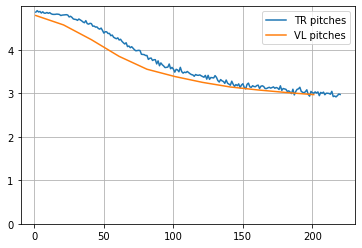

In [51]:
tr_losses = checkpoint['tr_losses']

#plt.plot(range(1, len(tr_losses['tot'])+1), tr_losses['tot'], label='TR loss')
#plt.plot(range(1, len(tr_losses['acts'])+1), tr_losses['acts'], label='TR acts')
plt.plot(range(1, len(tr_losses['pitches'])+1), tr_losses['pitches'], label='TR pitches')
#plt.plot(range(1, len(tr_losses['dur'])+1), tr_losses['dur'], label='TR dur')
#plt.plot(range(1, len(tr_losses['kld'])+1), tr_losses['kld'], label='TR kld')

val_losses = checkpoint['val_losses']
eval_every = checkpoint['eval_every']
print(eval_every)
#print(len(val_losses['tot']))

#plt.plot(range(1, len(tr_losses['tot'])+1, eval_every), val_losses['tot'], label='VL loss')
#plt.plot(range(1, len(tr_losses['acts'])+1, eval_every), val_losses['acts'], label='VL acts')
plt.plot(range(1, len(tr_losses['pitches'])+1, eval_every), val_losses['pitches'], label='VL pitches')
#plt.plot(range(1, len(tr_losses['dur'])+1, eval_every), val_losses['dur'], label='VL dur')
#plt.plot(range(1, len(tr_losses['kld'])+1, eval_every), val_losses['kld'], label='VL kld')

plt.grid()
plt.ylim(0)
plt.xlim()
plt.legend()

In [27]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.grid()
plt.ylim(0, 1)
plt.xlim()
plt.legend()

KeyError: 'accuracies'

(0.0, 44834.95)

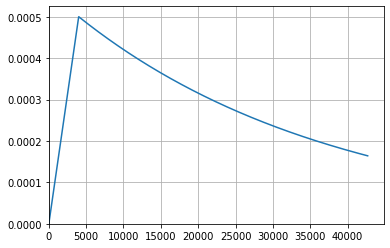

In [5]:
lrs = checkpoint['lrs']
plt.plot(range(1, len(lrs)+1), lrs, label='Lr')
plt.grid()
plt.ylim(0)
plt.xlim(0)

In [6]:
lrs[-1]

0.00016414210715827324

In [7]:
losses = checkpoint['losses']
losses['pitches'][-10:]

[0.028767479583621025,
 0.030669519677758217,
 0.024552132934331894,
 0.025488464161753654,
 0.015978669747710228,
 0.03437076881527901,
 0.02213248237967491,
 0.03187737986445427,
 0.031090669333934784,
 0.01868758536875248]

In [8]:
accs = checkpoint['accuracies']
accs['notes'][-10:]

[0.9824704527854919,
 0.9850452542304993,
 0.985401451587677,
 0.9848942756652832,
 0.9905087351799011,
 0.9814502596855164,
 0.9895327091217041,
 0.9849942326545715,
 0.9843013882637024,
 0.9901027679443359]

In [9]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cpu
Current device idx: 0


Reconstruct

In [10]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')
    
    
    def _get_node_features(self, acts, num_nodes):
        
        num_tracks = acts.shape[0]
        features = torch.zeros((num_nodes, num_tracks), dtype=torch.float)
        features[np.arange(num_nodes), np.stack(np.where(acts))[0]] = 1.
        
        return features


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot_p = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot_p[np.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to one-hot (dur)
        durs = seq_tensor[:, :, :, 1]
        onehot_d = np.zeros((durs.shape[0]*durs.shape[1]*durs.shape[2],
                            99), dtype=float)
        onehot_d[np.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        onehot_d = onehot_d.reshape(-1, durs.shape[1], seq_tensor.shape[2], 99)
        #bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]
        
        
        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot_p, onehot_d),
                                        axis=-1)
        #new_seq_tensor = onehot_p
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        # Third column -> edge_type, Fourth column -> timestep distance
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # No edges: add fictitious self-edge
        edge_index = (torch.LongTensor([[0], [0]]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        attrs = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        edge_attrs = torch.zeros(attrs.size(0), 1+seq_acts.shape[-1])
        edge_attrs[:, 0] = attrs[:, 0]
        edge_attrs[np.arange(edge_attrs.size(0)), attrs.long()[:, 1]+1] = 1
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        node_features = self._get_node_features(seq_acts, n)
        graph = Data(edge_index=edge_index, edge_attrs=edge_attrs,
                     num_nodes=n, node_features=node_features)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [11]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj
from typing import Callable
from torch_geometric.nn.inits import reset

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')

def masked_edge_attrs(edge_attrs, edge_mask):
    return edge_attrs[edge_mask, :]


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps edge features :obj:`edge_attr` of shape :obj:`[-1,
            num_edge_features]` to shape
            :obj:`[-1, in_channels * out_channels]`, *e.g.*, defined by
            :class:`torch.nn.Sequential`.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        nn: Callable,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        reset(self.nn)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None,
                edge_attr: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                attr = masked_edge_attrs(edge_attr, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size,
                                       edge_attr=attr)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        weight = self.nn(edge_attr)
        weight = weight.view(-1, self.in_channels_l, self.in_channels_l)
        return torch.matmul(x_j.unsqueeze(1), weight).squeeze(1)

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

In [22]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv#, RGCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    

class MLP(nn.Module):
    
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=256):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, output_dim)
        )
        

    def forward(self, x):
        return self.layers(x)


class GraphEncoder(nn.Module):
    
    def __init__(self, input_dim=256, dim_hidden=256, num_layers=3, num_relations=3,
                 edge_features_dim=32, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList()
        edge_nn = nn.Linear(edge_features_dim, input_dim*input_dim)
        self.layers.append(RGCNConv(input_dim, dim_hidden, num_relations, edge_nn))
        for i in range(num_layers-1):
            edge_nn = nn.Linear(edge_features_dim, dim_hidden*dim_hidden)
            self.layers.append(RGCNConv(dim_hidden, dim_hidden, num_relations, edge_nn))
        self.p = dropout

    def forward(self, data):
        x, edge_index, edge_attrs = data.x, data.edge_index, data.edge_attrs
        edge_type = edge_attrs[:, 0]
        edge_attr = edge_attrs[:, 1:]
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index, edge_type, edge_attr)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    def __init__(self, d_token=230, d_transf=256, nhead_transf=2, 
                 num_layers_transf=2, n_tracks=4, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GraphEncoder(dropout=dropout, input_dim=n_tracks+256)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Concatenate track one hot features with chord encodings
        # and compute node encodings
        x_graph.x = torch.cat((x_graph.node_features, pooled_encs), 1)
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(node_encs, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=230, d_model=256,
                 d_transf=256, nhead_transf=2, num_layers_transf=2, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = MLP(d_z, d_model, n_tracks*resolution)

        # GNN
        self.graph_decoder = GraphEncoder(dropout=dropout, input_dim=n_tracks+256)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, d_token)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        z_node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())
        
        # Add one-hot encoding of tracks
        # Todo: use also edge info
        x_graph.x = torch.cat((x_graph.node_features, z_node_features), 1)
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        # Prepare transformer memory
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())
        
        # Filter silences
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        # Todo: same embeddings as encoder?
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1, **kwargs):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


In [23]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [24]:
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [26]:
checkpoint = torch.load('models/pitchdurs_rgcn_ecc')

In [27]:
state_dict = checkpoint['model_state_dict']
vae = VAE().to(device)

In [28]:
vae.load_state_dict(state_dict)
vae.eval()

VAE(
  (encoder): Encoder(
    (embedding): Linear(in_features=230, out_features=256, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (ou

In [29]:
from torch.utils.data import Subset
import numpy as np
import os

ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
#loader = DataLoader(dataset, batch_size=64, shuffle=True)

n_samples = 128
subset = Subset(dataset, np.arange(n_samples))
loader = DataLoader(subset, batch_size=64, shuffle=False)
print(len(subset))

128


In [30]:
for idx, inputs in enumerate(loader):
    
    x_seq, x_acts, x_graph, src_mask = inputs
    x_seq = x_seq.float().to(device)
    x_acts = x_acts.to(device)
    x_graph = x_graph.to(device)
    src_mask = src_mask.to(device)
    tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(device)

    # Forward pass, get the reconstructions
    outputs, mu, log_var = vae(x_seq, x_acts, x_graph, src_mask, tgt_mask)
    
    break

seq_rec, _  = outputs

In [32]:
x_seq.size()

torch.Size([64, 4, 32, 16, 230])

In [33]:
# Construct dense reconstruction from sparse representation
seq_rec_dense = torch.zeros(x_seq.size(), dtype=torch.float).to(device)
seq_rec_dense = seq_rec_dense[..., 1:, :]
size = seq_rec_dense.size()

seq_rec_dense = seq_rec_dense.view(-1, seq_rec_dense.size(-2), seq_rec_dense.size(-1))

silence = torch.zeros(seq_rec_dense.size(-2), seq_rec_dense.size(-1)).to(device)
silence[:, 129] = 1. # eos token

seq_rec_dense[x_acts.bool().view(-1)] = seq_rec
seq_rec_dense[torch.logical_not(x_acts.bool().view(-1))] = silence

seq_rec_dense = seq_rec_dense.view(size)

In [57]:
music_real = x_seq[50]
music_rec = seq_rec_dense[50]

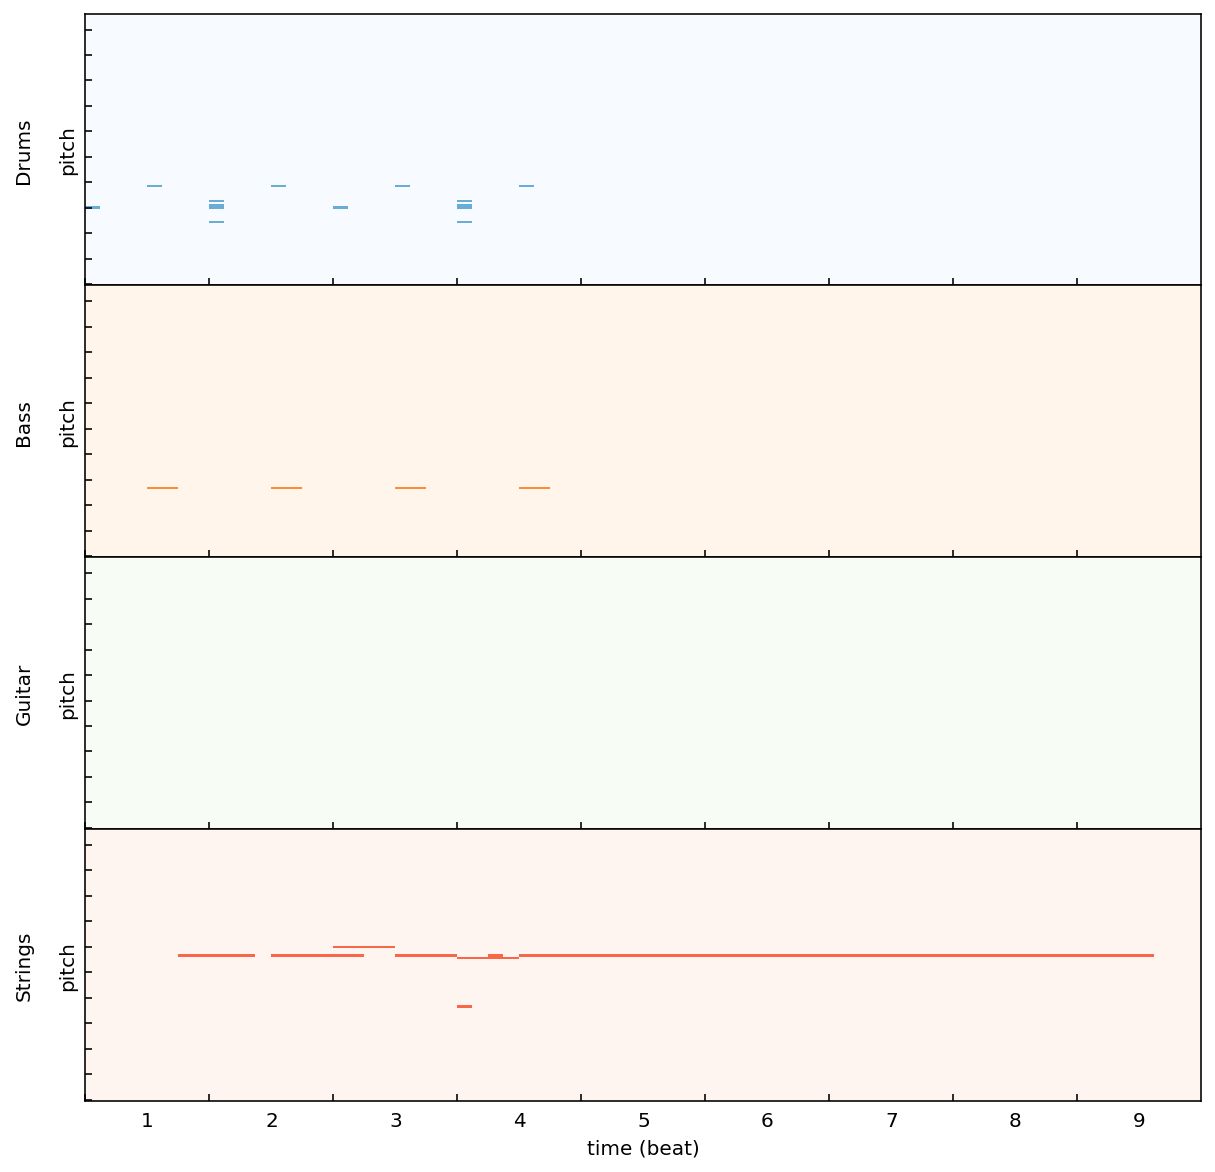

In [59]:
import muspy
from matplotlib import pyplot as plt

prefix = "data/music/"

real = from_tensor_to_muspy(music_real, track_data)

fig, axs_ = plt.subplots(4, sharex=True, figsize=(10,10))
fig.subplots_adjust(hspace=0)
axs = axs_.tolist()
muspy.show_pianoroll(music=real, yticklabel='off', grid_axis='off', axs=axs)
plt.savefig(prefix + "real" + ".png", dpi=200)
muspy.write_midi(prefix + "real" + ".mid", real)

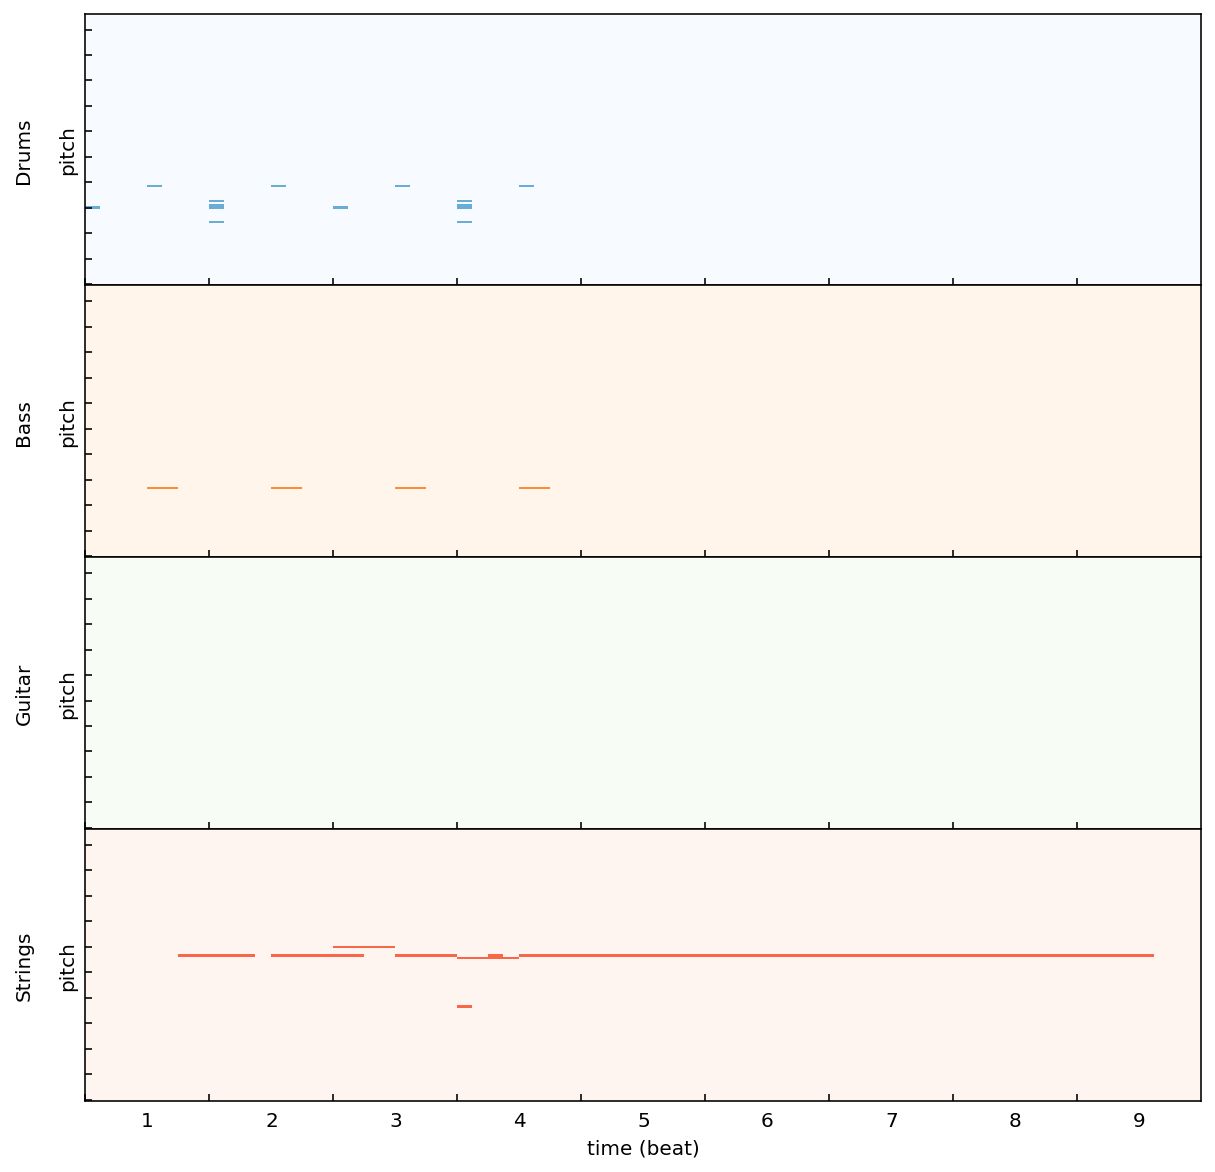

In [60]:
rec = from_tensor_to_muspy(music_rec, track_data)

fig, axs_ = plt.subplots(4, sharex=True, figsize=(10,10))
fig.subplots_adjust(hspace=0)
axs = axs_.tolist()

muspy.show_pianoroll(rec, yticklabel='off', grid_axis='off', axs=axs)
plt.savefig(prefix + "rec" + ".png", dpi=200)
muspy.write_midi(prefix + "rec" + ".mid", rec)

In [35]:
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [58]:
RESOLUTION = 8

#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    #dur = torch.dot(dur, powers).long()
                    dur = torch.argmax(dur) + 1
                    
                    if dur == 97 or dur == 98 or dur == 99:
                        dur = 4
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
                    #notes.append(muspy.Note(ts, pitch.item(), dur, 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

In [ ]:
prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)